In [10]:
%matplotlib inline
from Utils import utilities as utl
from MDP import frozen_lake_mdp as flmdp
from Offline_RL import CQL
from Gumbel_Max_Scm import gumble_max_scm_counterfacutal as gscmcf
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import random
%matplotlib inline
import numpy as np
import os
from matplotlib.patches import Patch

#os.getcwd()

#### Frozen lake Env setup 

frozen lake map size: 4x4
tx_mat_full shape: (4, 16, 16), r_mat_full shape: (4, 16, 16)
All possible states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
All possible actions: [0, 1, 2, 3]
Goal state: 15
Hole states: [5, 7, 11, 12]
{15: 1, 5: -0.15, 7: -0.15, 11: -0.15, 12: -0.15}
first state: 0


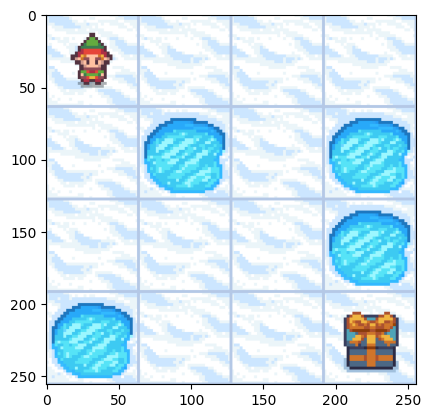

In [2]:
envdim=4
map=str(envdim)+'x'+str(envdim)
print(f"frozen lake map size: {map}")
#print(map)
env=utl.make_env(map,True)
obj_Frozen_MDP=flmdp.Frozen_MDP(env,envdim,-0.15) #from MDP import frozen_lake_mdp as flmdp
print("first state: %s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

#### Base policy/Behaviour  training (standard Q learning)

All possible states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


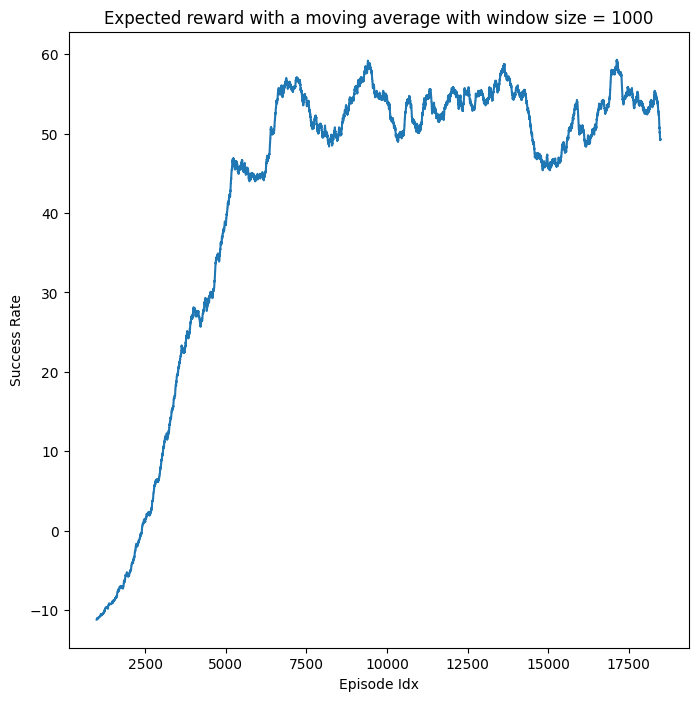

In [14]:
rewards,q_table,epsilon=utl.Qlearning(env, n=30000, max_steps=50,epsilon = 0.25,hole_states=obj_Frozen_MDP.hole_states)
utl.plot_rewards(rewards)

#### Target Agent using Conservative Q-learning (CQL)¶
#### - Can be  of-policy as well offline
#### - State is one hot encoded  Grid posistion

In [4]:
agent_full = CQL.CQLAgent(state_size= 2*envdim,
                  action_size=env.action_space.n,hidden_size=32,
                  device="cpu")
fl_obj=utl.expt_cf_utility_frozen_lake(env,agent_full,obj_Frozen_MDP.hole_states,obj_Frozen_MDP.matrix_to_seq_dct,q_table,max_steps=50)
    #def __init__(self,env,agent,hole_states,matrix_to_seq_dct,q_table,max_steps=100,epsilon=0.10)
obs_arr=fl_obj.base_trajectories_fronzen_lake(n=1000,epsilon=0.10)
obj_process,obj_exp=utl.process_obs_for_traj(obs_arr)


 base policy obeservations shape: (1000, 50, 6)


#### Trajectory sampling under Base policy /behavior Policy (trained above using standard Q learning)

len(buffer.memory): 26947
experiences: 26947, max_epsilon: 1.0, min_epsilon: 0.01


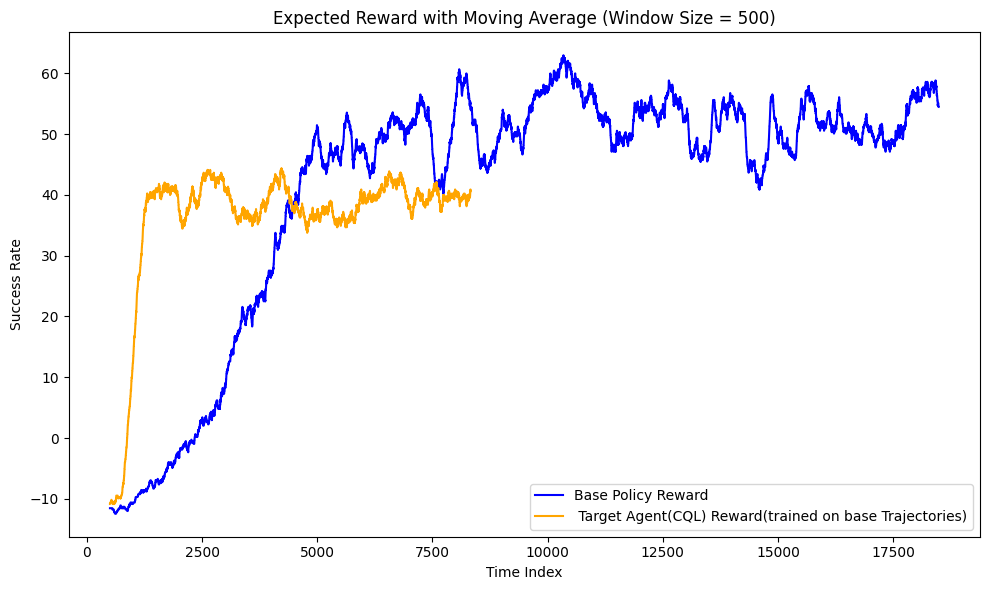

In [5]:
buffer_size=100000
buffer = CQL.ReplayBuffer(buffer_size=buffer_size, batch_size=32, device="cpu")
fl_obj.collect_random_fronzen_lake( buffer,obj_exp)
print(f"len(buffer.memory): {len(buffer.memory)}")
rewardsl,agent_full=fl_obj.train_cql_fronzen_lake(buffer,episodes=15000,min_eps=0.01,max_steps=50)
batch_policy_reward = rewards
offline_cql_reward = rewardsl
utl.plot_all_rewards(batch_policy_reward, offline_cql_reward, window=500)

In [6]:
frames=fl_obj.play_game_fronzen_lake(agent_full,eps=0.10,tries=100)
clip = mpy.ImageSequenceClip(frames, fps=10)
clip.ipython_display()

Tries: = 0
success: episode = 20, steps = 32
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


#### Mdp is a simple 𝑓(𝑎~,𝑝𝑜𝑠𝑖𝑡𝑖𝑜𝑛) ; please refer MDP.py

In [7]:
#from MDP import frozen_lake_mdp1 as flmdptest
obj_Frozen_MDP=flmdp.Frozen_MDP(env,envdim,-0.15) #from MDP import frozen_lake_mdp as flmdp


tx_mat_full shape: (4, 16, 16), r_mat_full shape: (4, 16, 16)
All possible states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
All possible actions: [0, 1, 2, 3]
Goal state: 15
Hole states: [5, 7, 11, 12]
{15: 1, 5: -0.15, 7: -0.15, 11: -0.15, 12: -0.15}


#### Main Counterfactual Trajectories generation under Target policy , sample episodes to understand deviations

In [8]:
scm_obj=gscmcf.gumble_max_scm_process(agent_full,obs_arr,obj_Frozen_MDP.matrix_to_seq_dct,obj_Frozen_MDP.r_mat_full,obj_Frozen_MDP.tx_mat_full,obj_Frozen_MDP.NUM_FULL_STATES,n_cf_samps=5)
traj_arr_ls=scm_obj.process_cf_trajs()
df=gscmcf.cf_traj_comaprision(obj_exp,traj_arr_ls)

**** Main posterior Class Gumbel SCM ***
batch trajectories shape: (1000, 50, 6)
batch trajectories: 1000, batch steps: 50
CF trajectories generated: (1000, 5, 50, 5)
base Trajectories: 1000, CF Trajectories: 1000
index: 0 | basepolicy_reward: 0.0 | conterfactual_mean: 0.0 | conterfactual_traj_rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
index: 1 | basepolicy_reward: 0.0 | conterfactual_mean: 0.0 | conterfactual_traj_rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
index: 2 | basepolicy_reward: 1.0 | conterfactual_mean: 1.0 | conterfactual_traj_rewards: [1.0, 1.0, 1.0, 1.0, 1.0]
index: 3 | basepolicy_reward: 1.0 | conterfactual_mean: 1.0 | conterfactual_traj_rewards: [1.0, 1.0, 1.0, 1.0, 1.0]
index: 4 | basepolicy_reward: -0.15 | conterfactual_mean: 0.4 | conterfactual_traj_rewards: [0.0, 0.0, 0.0, 1.0, 1.0]
index: 5 | basepolicy_reward: -0.15 | conterfactual_mean: -0.06 | conterfactual_traj_rewards: [0.0, -0.15, 0.0, 0.0, -0.15]
index: 6 | basepolicy_reward: -0.15 | conterfactual_mean: -0.03 | conterfactual_

##### Diagnostics on deviations 

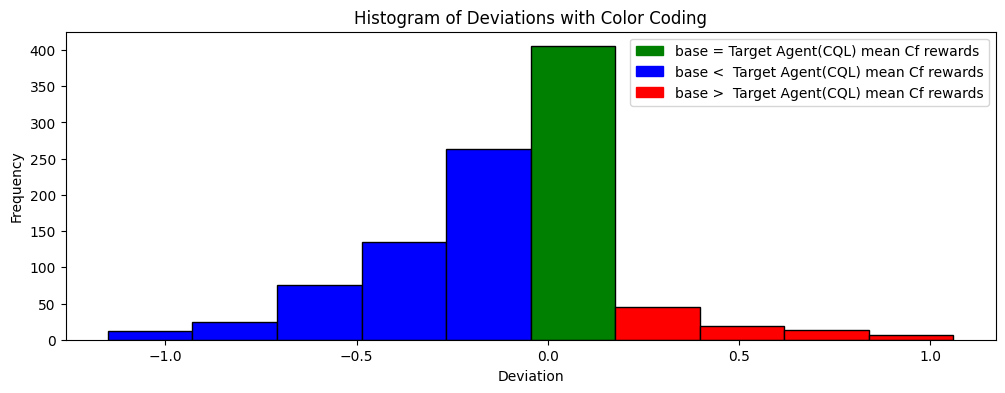

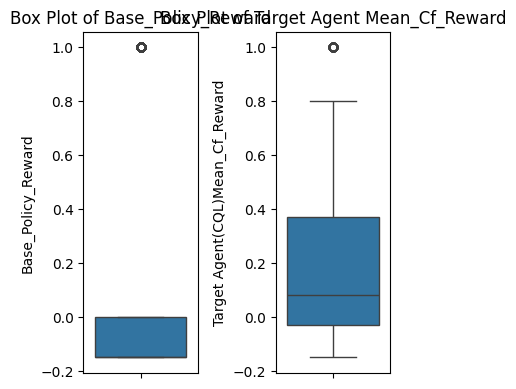

In [9]:
df['Absolute_Deviation'] = abs(df['Base_Policy_Reward'] - df['Mean_Cf_Reward'])
df['Deviation'] = df['Base_Policy_Reward'] - df['Mean_Cf_Reward']
df['Target Agent(CQL)Mean_Cf_Reward']=df['Mean_Cf_Reward']
utl.histogram(df)
utl.boxplot(df)